In [1]:
# -1-) Notlar
"""
    Her ilce icin esit sayida veri yok. Bu sayilar ilce_tarih_sayilari degiskeninde tutulu.

    Yapilmasi gerekenler:
        - Kesinti sayilarinin tarihe bagli ayri ayri grafiklerini cikart. (veya beraber de olabilir)
        - Hava kosullarindan iyi, orta, kotu, cok kotu gibi bir bilgi cikartmaya calis. Belki burada yapay zeka
        kullanabilirsin. orda bir formül belirlemek lazim ona göre siniflandirilir.
        
"""

"\n    Her ilce icin esit sayida veri yok. Bu sayilar ilce_tarih_sayilari degiskeninde tutulu.\n\n    Yapilmasi gerekenler:\n        - Weather'daki verileri gunluge cevir. ++++\n        - Her ilce icin hava durumu verilerini(bir gun icin ortalama alaraktan), tarihleri, tatil_flag'lari\n        kesinti sayilarini tutan bir DataFrame olustur. ++++\n        - Kesinti sayilarinin tarihe bagli ayri ayri grafiklerini cikart. (veya beraber de olabilir)\n        - Hava kosullarindan iyi, orta, kotu, cok kotu gibi bir bilgi cikartmaya calis. Belki burada yapay zeka\n        kullanabilirsin. orda bir formül belirlemek lazim ona göre siniflandirilir.\n        \n"

In [2]:
# 0-) Import required moduls and libraries

import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import os
from unidecode import unidecode # to convert Turkish characters to English
from statsmodels.tsa.seasonal import seasonal_decompose as sm
import statsmodels.api as sa
# bildirimisiz_sum tahmin edilecek

In [3]:
# 1-) read and preproccess train.csv
train = pd.read_csv("./train.csv") # 46.944 satir, 4 kolon

#print(train) # 1.098 farkli tarih var, 47 farkli ilce var

tarihler = []
for i in train["tarih"]:
    tarihler.append(datetime.strptime(i, "%Y-%m-%d"))
train["tarih"] = tarihler

#print(train.dtypes)

dict = {}
for label, group in train.groupby("ilce"):
    dict[label] = group

ilceler = (list(dict.keys()))
print(dict["izmir-konak"]) # keys olarak her ilceyi, values olarak o ilcelerin bulundugu satirlari icerir

           tarih         ilce  bildirimsiz_sum  bildirimli_sum
30436 2021-01-01  izmir-konak                9               0
30437 2021-01-02  izmir-konak                5               0
30438 2021-01-03  izmir-konak                5               0
30439 2021-01-04  izmir-konak               11               0
30440 2021-01-05  izmir-konak               11               0
...          ...          ...              ...             ...
31527 2023-12-30  izmir-konak               10               1
31528 2023-12-31  izmir-konak                9               0
31529 2024-01-01  izmir-konak               11               0
31530 2024-01-02  izmir-konak                9               1
31531 2024-01-03  izmir-konak                8               1

[1096 rows x 4 columns]


In [4]:
# 2-) extract ilce and keep preprocessing train.csv
"""
for label in dict.keys(): # her ilce icin bildirimsiz ve bildirimli olarak grafiklerini cikart
    print(dict[label]["bildirimsiz_sum"])
    plt.figure(figsize=(14,6))
    plt.bar(dict[label]["tarih"],dict[label]["bildirimsiz_sum"])
    plt.title(label)
    plt.xticks(rotation=90)
    plt.show()
"""
"""
plt.figure(figsize=(14,6))
plt.bar(dict["izmir-konak"]["tarih"],dict["izmir-konak"]["bildirimsiz_sum"])
plt.title(label)
plt.margins(0.01)
plt.xticks(rotation=90)
plt.show()
"""
# ilce tarih sayilarini al hepsinde esit veri yok
ilce_tarih_sayilari = {}
for name in dict.keys():
    ilce_tarih_sayilari[name] = len(list(dict[name]["tarih"].to_dict().values()))

print(ilce_tarih_sayilari)
for name in dict.keys():
    dict[name].set_index("tarih", inplace=True)

#train.set_index("tarih", inplace=True) # train'in tarih kolonunu indexe cevir
print(train)

{'izmir-aliaga': 1078, 'izmir-balcova': 681, 'izmir-bayindir': 1078, 'izmir-bayrakli': 1059, 'izmir-bergama': 1092, 'izmir-beydag': 658, 'izmir-bornova': 1096, 'izmir-buca': 1087, 'izmir-cesme': 1097, 'izmir-cigli': 1044, 'izmir-dikili': 1091, 'izmir-foca': 1058, 'izmir-gaziemir': 898, 'izmir-guzelbahce': 835, 'izmir-karabaglar': 1072, 'izmir-karaburun': 1063, 'izmir-karsiyaka': 1057, 'izmir-kemalpasa': 1091, 'izmir-kinik': 889, 'izmir-kiraz': 1069, 'izmir-konak': 1096, 'izmir-menderes': 1097, 'izmir-menemen': 1091, 'izmir-narlidere': 758, 'izmir-odemis': 1096, 'izmir-seferihisar': 1086, 'izmir-selcuk': 853, 'izmir-tire': 1079, 'izmir-torbali': 1096, 'izmir-urla': 1094, 'manisa-ahmetli': 600, 'manisa-akhisar': 1098, 'manisa-alasehir': 1091, 'manisa-demirci': 918, 'manisa-golmarmara': 555, 'manisa-gordes': 1033, 'manisa-kirkagac': 925, 'manisa-koprubasi': 781, 'manisa-kula': 1013, 'manisa-salihli': 1098, 'manisa-sarigol': 1000, 'manisa-saruhanli': 1079, 'manisa-sehzadeler': 1095, 'manis

In [23]:
# 3-) read and preprocess weather.csv

weather = pd.read_csv("./weather.csv")
print(weather.columns) # onemli kolonlar: date, t_apparent:C (hissedilen sicaklik), wind_dir_10m:d (ruzgar yonu),
# wind_speed_10m:ms (ruzgar hizi), prob_precip_1h:p (yagis), ilce

# ilceleri ayir
ilce_weather = {} # keys olarak ilceleri, values olarak o ilcelerin saatlik hava durumklarini tutar
for label, group in weather.groupby("ilce"):
    ilce_weather[label] = group


# tarihleri tarih formatina cevir
#print(ilce_weather["izmir-konak"].dtypes)
for name in ilce_weather.keys():
    tarihler = []
    for date in ilce_weather[name]["date"]:
        tarihler.append(datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
    ilce_weather[name]["date"] = tarihler
print("bitti")
#print(ilce_weather["izmir-konak"].dtypes)


# tarihleri indexe cevir
for name in ilce_weather.keys():
    ilce_weather[name].set_index("date", inplace=True)


# tarhileri gun olarak birlestir
for name in ilce_weather.keys():
    ilce_weather[name] = ilce_weather[name].resample("D").mean()


# tarih kolonunu tekrardan olustur
for name in ilce_weather.keys():
    ilce_weather[name]["tarih"] = ilce_weather[name].index
print(ilce_weather["izmir-konak"].head())

Index(['date', 'lat', 'lon', 't_2m:C', 'effective_cloud_cover:p',
       'global_rad:W', 'relative_humidity_2m:p', 'wind_dir_10m:d',
       'wind_speed_10m:ms', 'prob_precip_1h:p', 't_apparent:C', 'ilce'],
      dtype='object')
bitti
                lat      lon     t_2m:C  effective_cloud_cover:p  \
date                                                               
2021-01-01  38.4177  27.1283  13.095833                59.033333   
2021-01-02  38.4177  27.1283  13.379167                29.912500   
2021-01-03  38.4177  27.1283  12.587500                69.916667   
2021-01-04  38.4177  27.1283  13.783333                45.604167   
2021-01-05  38.4177  27.1283  13.895833                35.670833   

            global_rad:W  relative_humidity_2m:p  wind_dir_10m:d  \
date                                                               
2021-01-01     65.212500               87.962500      137.558333   
2021-01-02     91.225000               80.720833      134.820833   
2021-01-03     34

C:\Users\ökkeş\AppData\Local\Temp\ipykernel_10256\2691552121.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ilce_weather[name] = ilce_weather[name].resample("D").mean()


In [6]:
# 4-) read and preprocess holidays.csv

holiday = pd.read_csv("./holidays.csv")

print(holiday.head())

holiday["tarih"] = holiday['Yıl'].astype(str) + '-' + holiday['Ay'].astype(str) + '-' + holiday['Gün'].astype(str)
holiday['tarih'] = pd.to_datetime(holiday['tarih'], format='%Y-%m-%d')
holiday.set_index("tarih", inplace=True)
holiday = holiday.drop(columns=["Yıl", "Ay", "Gün"])

print(holiday.head()) # index olarak tarihi (YY-AA-GG), Bayram_Flag olarak da bayram ismini tutar


    Yıl  Ay  Gün                              Bayram_Flag
0  2021   1    1                                  Yılbaşı
1  2021   4   23        Ulusal Egemenlik ve Çocuk Bayramı
2  2021   5    1                   Emek ve Dayanışma Günü
3  2021   5   19  Atatürk'ü Anma, Gençlik ve Spor Bayramı
4  2021   7   15           Demokrasi ve Millî Birlik Günü
                                        Bayram_Flag
tarih                                              
2021-01-01                                  Yılbaşı
2021-04-23        Ulusal Egemenlik ve Çocuk Bayramı
2021-05-01                   Emek ve Dayanışma Günü
2021-05-19  Atatürk'ü Anma, Gençlik ve Spor Bayramı
2021-07-15           Demokrasi ve Millî Birlik Günü


In [7]:
# 5-) merge the train data and holidays, return a new dict called dict_holiday

def merge_holiday(df1, df2):
    merged_df = pd.merge(df1, df2["Bayram_Flag"], left_index=True, right_index=True, how="left")
    #df1["Bayramlar"] = df2["Bayram_Flag"]
    return merged_df

dict_holiday = {}
for name in dict.keys():
    dict_holiday[name] = merge_holiday(dict[name],holiday)
    dict_holiday[name]['tarih'] = dict_holiday[name].index
    dict_holiday[name] = dict_holiday[name].reindex(columns=["tarih", "ilce", "bildirimsiz_sum", "bildirimli_sum", "Bayram_Flag"])
    
print(dict_holiday["izmir-konak"])

                tarih         ilce  bildirimsiz_sum  bildirimli_sum  \
tarih                                                                 
2021-01-01 2021-01-01  izmir-konak                9               0   
2021-01-02 2021-01-02  izmir-konak                5               0   
2021-01-03 2021-01-03  izmir-konak                5               0   
2021-01-04 2021-01-04  izmir-konak               11               0   
2021-01-05 2021-01-05  izmir-konak               11               0   
...               ...          ...              ...             ...   
2023-12-30 2023-12-30  izmir-konak               10               1   
2023-12-31 2023-12-31  izmir-konak                9               0   
2024-01-01 2024-01-01  izmir-konak               11               0   
2024-01-02 2024-01-02  izmir-konak                9               1   
2024-01-03 2024-01-03  izmir-konak                8               1   

           Bayram_Flag  
tarih                   
2021-01-01     Yılbaşı  
2

In [22]:
# 5-) merge the dict_holiday and weather, return merged_all which contains all of the required columns

def merge_weather(df1, df2):
    merged_df = pd.merge(df1, df2[["t_2m:C","relative_humidity_2m:p","wind_speed_10m:ms","prob_precip_1h:p"]], left_index=True, right_index=True, how="left")
    return merged_df

merged_all = {} # key olarak tum ilceler, values olarak kesintiler, bayramlar, hava durumu verilerini tutan df'i tutar
for name in dict_holiday.keys():
    merged_all[name] = merge_weather(dict_holiday[name], ilce_weather[name])
    merged_all[name].columns = ["Tarih", "Ilce", "Bildirimsiz_sum", "Bildirimli_sum", # tekrar isimlendir
    "Bayram_Flag", "Sicaklik", "Bagil_Nem", "Ruzgar_Hizi", "Yagis"]
    merged_all[name]['Gün'] = range(1, len(merged_all[name]) + 1)

print(merged_all["izmir-konak"].tail())
print(merged_all["izmir-konak"].shape)

merged_all_week = {}
for name in merged_all.keys():
    merged_all_week[name] = merged_all[name].resample("W").mean(numeric_only=True)
#print(merged_all_week["izmir-konak"])

                Tarih         Ilce  Bildirimsiz_sum  Bildirimli_sum  \
tarih                                                                 
2023-12-30 2023-12-30  izmir-konak               10               1   
2023-12-31 2023-12-31  izmir-konak                9               0   
2024-01-01 2024-01-01  izmir-konak               11               0   
2024-01-02 2024-01-02  izmir-konak                9               1   
2024-01-03 2024-01-03  izmir-konak                8               1   

           Bayram_Flag   Sicaklik  Bagil_Nem  Ruzgar_Hizi      Yagis   Gün  
tarih                                                                       
2023-12-30         NaN  13.262500  85.512500     2.391667   1.000000  1092  
2023-12-31         NaN  14.383333  83.904167     1.991667   1.000000  1093  
2024-01-01     Yılbaşı  13.379167  86.258333     2.104167  11.591667  1094  
2024-01-02         NaN  12.662500  90.912500     2.645833   4.487500  1095  
2024-01-03         NaN  13.112500  89.22

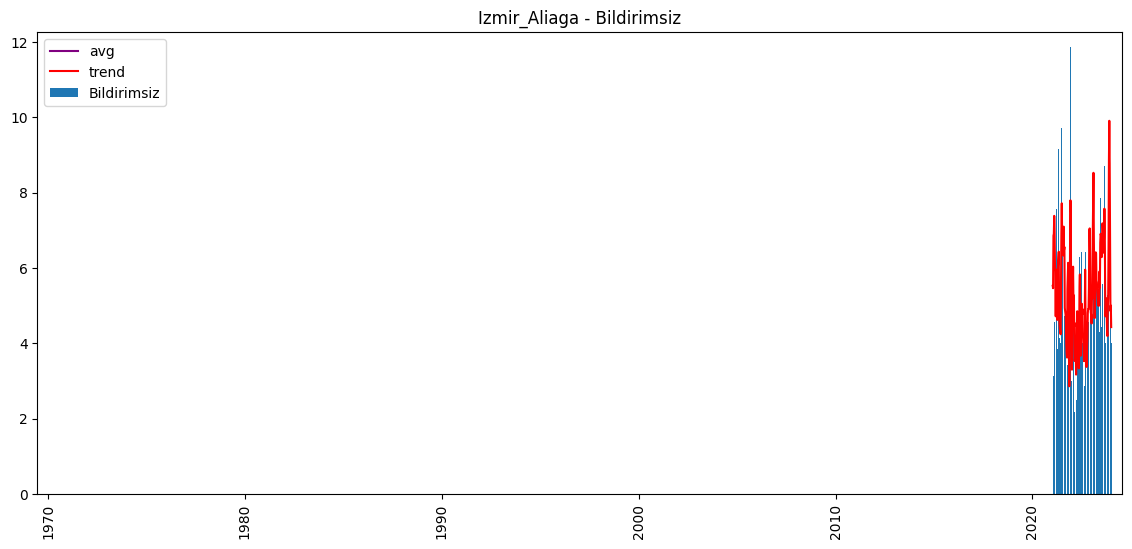

In [18]:
# 6-) her ilce icin grafikleri olustur. (trend, tahmin gibi parametreleri de göster)

plt.figure(figsize=(14,6))
plt.bar(merged_all_week["izmir-aliaga"].index,merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], width=5, label="Bildirimsiz")
plt.margins(0.01)
plt.title("Izmir_Aliaga - Bildirimsiz")
plt.xticks(rotation=90)
ayristirma2 = sm(merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], model="mul", period=3)
#plt.plot(merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"].mean(), label="avg", color="purple")
"""
analiz = pd.concat([
    ayristirma2.observed,
    ayristirma2.trend,
    ayristirma2.seasonal,
    ayristirma2.observed/ayristirma2.seasonal # orijinal veri / S = T * E, regr. da üzerine tahmin yapılacak sey
], axis=1)
analiz.columns = ["Orijinal Gözlem", "Trend", "Mevsimsellik", "Mevsimsellik Düzeltme"]

indeks = np.arange(1,len(df.index) + 1)


X = sa.add_constant(indeks)
model = sa.OLS(analiz["Mevsimsellik Düzeltme"], X)
sonuc = model.fit()

y = pd.date_range(analiz.index[-1] + pd.DateOffset(month=3), periods=4,freq="M") # 4 tane ekstra ay ekle

yeni_satirlar = pd.DataFrame(index=y)
analiz = pd.concat([analiz, yeni_satirlar])

# not: bu degerleri ayarla
mev = [
    1.038656,
    0.973940,
    0.987404,
    1.038656
]

nan_indices = analiz.index[analiz['Mevsimsellik'].isna()]
for i, index in enumerate(nan_indices):
    if i < len(mev):
        analiz.at[index, 'Mevsimsellik'] = mev[i]
print(analiz["Mevsimsellik"])

girdi = np.arange(1,len(df.index) + 5)
regmodel = sonuc.predict(sa.add_constant(girdi))

analiz["Tahmin"] = analiz["Mevsimsellik"] * regmodel


plt.plot(analiz["Mevsimsellik Düzeltme"], label="Mevsimsellik Düzeltme")
plt.plot(analiz["Orijinal Gözlem"], label="Orijinal Gözlem")
plt.plot(analiz["Tahmin"], label="Tahmin")
"""
plt.plot(ayristirma2.trend, color="red", label="trend")
plt.legend()
plt.show()


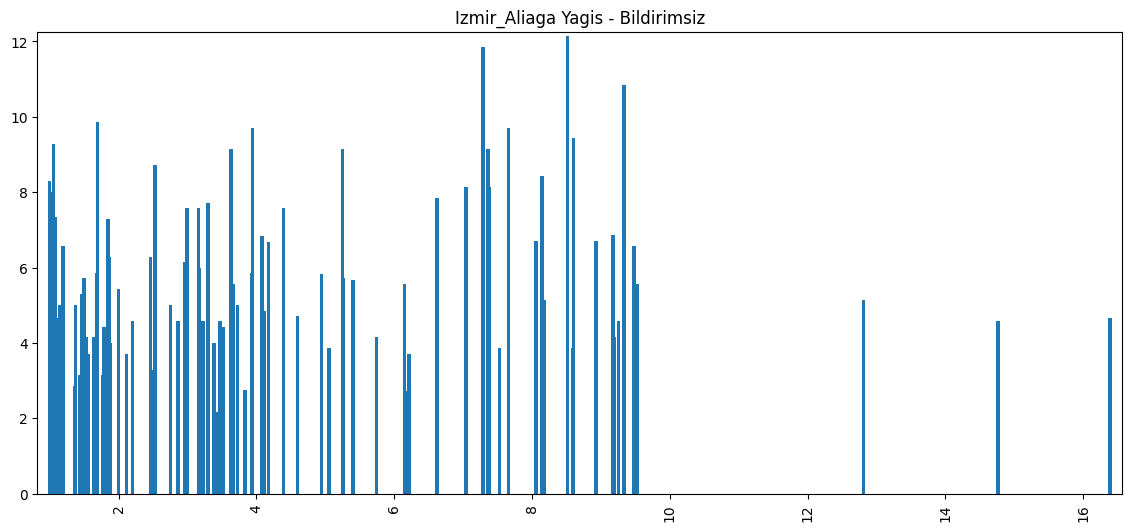

same as here


In [10]:
# 7-) farkli tur degiskenler arasi iliskeler grafiklenmeli (denenecek)

plt.figure(figsize=(14,6))
plt.bar(merged_all_week["izmir-aliaga"]["Yagis"],merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], width=0.05, label="Bildirimsiz")
plt.margins(0.01)
plt.title("Izmir_Aliaga Yagis - Bildirimsiz")
plt.xticks(rotation=90)
plt.show()
print("same as here")